# Task Description
1. Both the training and testing data sets have the same schema.<br/>
2. The first column is the binary target - 0 or 1. The rest of columns are variables<br/>
3. Do not assume data is clean. Please include basic sanity checks on data.<br/>
4. Use the training data set to build the best linear and non-linear classification model.<br/>
5. Use the testing data set to evaluate model performance.  Use appropriate metrics.<br/>
6. Rank order variables in terms of importance and provide your reasoning. <br/>

In [1]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from collections import Counter
%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

/Users/yujzhang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Sanity Check

In [2]:
# load data, check sample size
train = pd.read_csv('data_train.csv', header=None)
test = pd.read_csv('data_test.csv', header=None)
print('train data size: ', train.shape, 'test data size:', test.shape)

('train data size: ', (27914, 97), 'test data size:', (13834, 97))


In [3]:
# check if there are any columns with missing data
# return a list of [columns, # missing data]
print('train:', [[idx,i] for idx, i in enumerate(train.isnull().sum().tolist()) if i > 0])
print('test:', [[idx,i] for idx, i in enumerate(test.isnull().sum().tolist()) if i > 0])

('train:', [])
('test:', [])


In [4]:
# separate dependent and independent variables
X_train = train.drop(0, axis=1)
y_train = train[0]
X_test = test.drop(0, axis=1)
y_test = test[0]

## Check Data Type

In [5]:
# check the data types of dependent varaibles (categorical or continous)
def check_data_type(data):
    """
    Args:
        data: pandas DataFrame
    Return:
        pandas DataFrame: column: column name | num_unique: unique number of values in the columns | values: unique values of the column
    """
    data_type = pd.DataFrame()
    for i in data.columns:
        col_res = pd.DataFrame({'columns': i, 'num_unique': len(data[i].unique()), 'values': [sorted(data[i].unique())]})
        if data_type.empty:
            data_type = col_res
        else:
            data_type = data_type.append(col_res, ignore_index=True)
    return data_type
# all the 96 variables are categorical, 
# and it looks the categorical variables have already been scaled, 
# so feature scaling is not performed here anymore
col_unique_values = check_data_type(X_train)
print('Number of Independent Variables: ', len(X_train.columns))
print(col_unique_values)

('Number of Independent Variables: ', 96)
    columns  num_unique                                             values
0         1           7  [-0.95142, 0.079417, 0.28296, 0.357764, 0.5211...
1         2           4         [-0.787801, -0.055932, 0.229451, 0.808253]
2         3           6  [-1.049688, -0.935242, -0.542081, -0.2504, 0.0...
3         4           7  [-0.505371, -0.055118, 0.048823, 0.223265, 0.2...
4         5           5  [-0.500919, 0.167896, 0.410578, 0.647926, 1.04...
5         6          16  [-1.226213, -1.079333, -0.671476, -0.590935, -...
6         7           5  [-0.165978, 0.006456, 0.197074, 0.343797, 0.45...
7         8           5    [-0.167039, 0.0091, 0.192798, 0.347538, 0.4579]
8         9           5  [-0.165978, 0.006456, 0.197074, 0.343797, 0.45...
9        10           5  [-0.165978, 0.006456, 0.197074, 0.343797, 0.45...
10       11           5    [-0.167039, 0.0091, 0.192798, 0.347538, 0.4579]
11       12           7  [-0.822784, -0.332658, -0.159438,

## Downsampling

In [6]:
# check if the two classes are extramely imbalance
# class 0 : class 1 ~ 2.5 : 1, 
# pay attention to precision/recall for minority class and decide if unsampling is needed
print(Counter(train[0]))

Counter({0: 19706, 1: 8208})


In [7]:
from sklearn.utils import resample
def downsampling(df, target):
    # Separate majority and minority classes
    df_majority = df[df[target]==0]
    df_minority = df[df[target]==1]

    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=len(df_minority),     # to match minority class
                                     random_state=1314) # reproducible results

    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    return df_downsampled

In [8]:
train_ds = downsampling(train, 0)
Counter(train_ds[0])

Counter({0: 8208, 1: 8208})

In [9]:
# separate dependent and independent variables for downsampled data
X_train_ds = train_ds.drop(0, axis=1)
y_train_ds = train_ds[0]

## Correlation Analysis 
- there are highly correlated variables (pearson correlation > 0.8), such as <br/>
            8-11, 13-16, 24-28, 30-33, 42-46, 48-51, 42-46 with 24-28, 47-51 with 29 -33 etc.
    Principal Componenet Analysis (PCA) can be used to reduce dimensions while combing  
- all the Xs' are slightly positively correlated with y, the maximum correlation is only 0.29 

In [10]:
def plot_corr_matrix(corr):
    '''
    Plotting a diagonal correlation matrix
    Source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
    Args:
        corr: pandas DataFrame, correlation matrix
    '''
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20,20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

('maximum correlated with y', 0.29710843680836313)


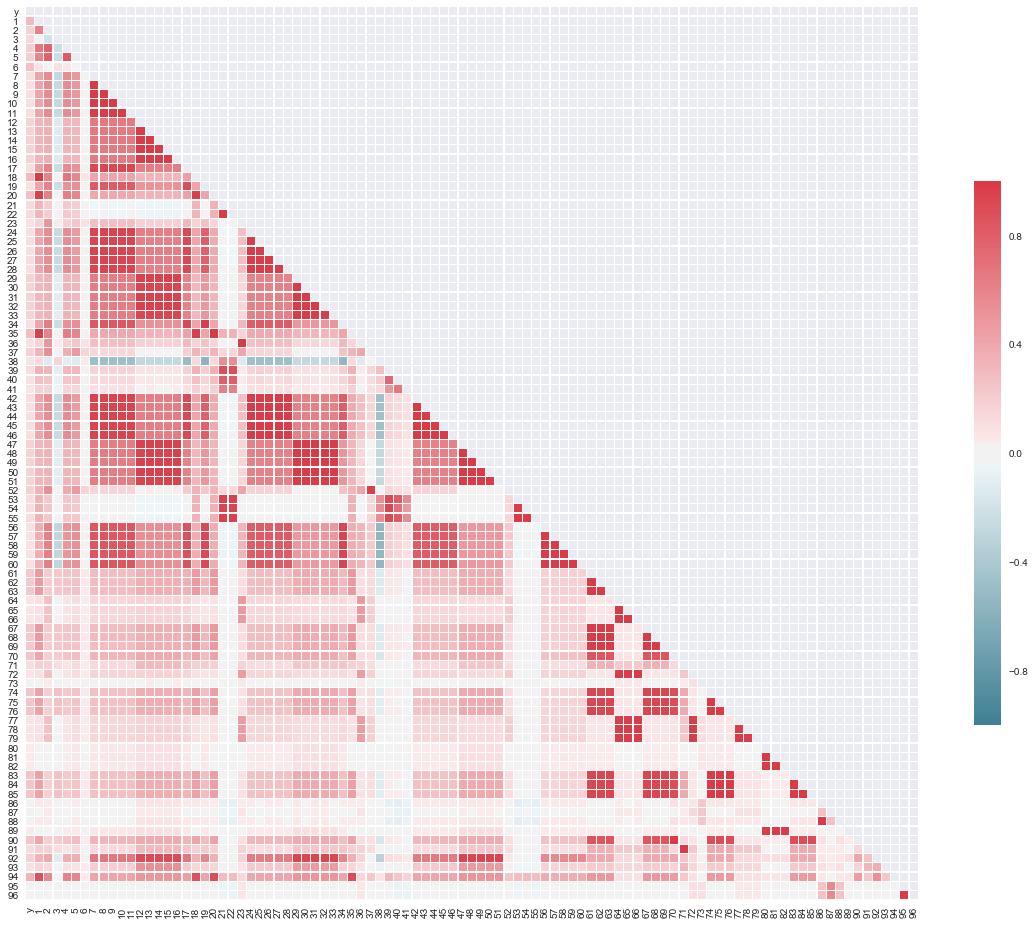

In [11]:
corr = train.rename(columns={0:'y'}).corr()
print('maximum correlated with y', corr['y'].sort_values(ascending=False)[1])
plot_corr_matrix(corr)

In [12]:
# take a closer look at column 30-33, 
# column 30, 33 are exactly the same, column 31, 21 are exacly the same
# so after removing duplicated columns, only 2 columns are remaining
train[[30, 31, 32, 33]].T.drop_duplicates().T.head()

,30,31
0,-0.158037,-0.159438
1,-0.158037,-0.159438
2,-0.158037,-0.159438
3,-0.158037,-0.159438
4,-0.158037,-0.159438


# Feature Selection

## Remove duplicated columns
As adjoining nearly correlated variables increases the contribution of their common underlying factor to the PCA, <br/>deplicated columns should be removed before PCA to avoid overemphasize their contribution

In [13]:
# As applying drop_duplicates to the whole 96 needs too many recursions, 
# we can first group columns by unique values of each column
# then check if the columns with the same unique values are duplicate
# if so, remove the duplicates
col_unique_values['values'] = col_unique_values['values'].astype(str)
df_grouped_cols = pd.DataFrame(col_unique_values.groupby('values')['columns'].apply(list)).reset_index()
# store the list 
col_rm_duplicates = []
for cols in df_grouped_cols['columns'].tolist():
    if len(cols) > 1: # if there are more than 1 column have the same unique values, check duplicate
        col_rm_duplicates.extend(np.array(train[cols].T.drop_duplicates().T.columns))
    else:
        col_rm_duplicates.extend(np.array(cols))

In [14]:
X_train_rm = X_train[col_rm_duplicates]
X_test_rm = X_test[col_rm_duplicates]
print('Number of variables after removing duplicated columns: ', X_train_rm.shape[1])

('Number of variables after removing duplicated columns: ', 63)


**Correlation Matrix after Removing Duplicated Columns**
- There are still groups of columns that are highly correlated, such as 62,68,84,75,67,61,63,83,74,90 
- Taking a closer look of this groups, we will find the columns are only slight different in values
- So the next step is to perform feature selection to additionally deal with the issue

('maximum correlated with y', 0.29710843680836313)


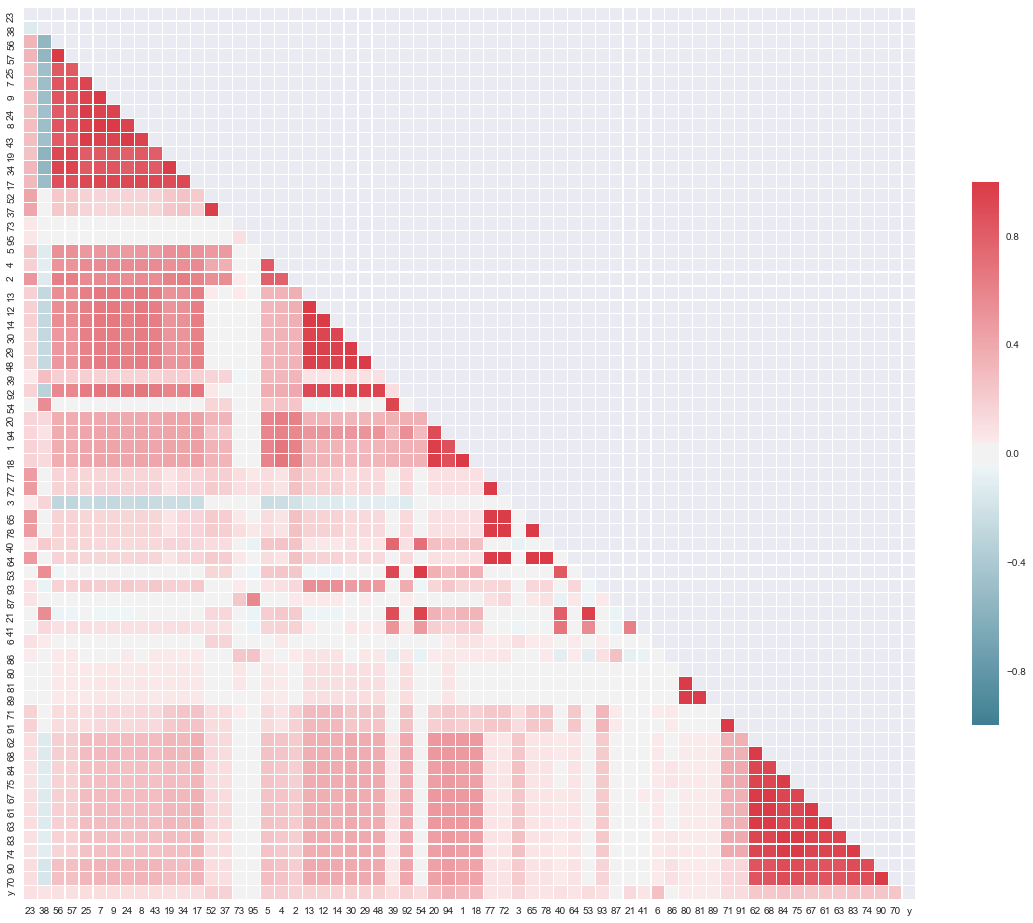

In [15]:
train_rm = X_train_rm.copy()
train_rm['y'] = y_train
corr = train_rm.corr()
print('maximum correlated with y', corr['y'].sort_values(ascending=False)[1])
plot_corr_matrix(corr)

## Colinear Variables (VIF > 5)

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_(df, threshhold=5.0):
    X = df.copy()
    X.columns = ['col_' + str(i) for i in X.columns]
    variables = range(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(0, X[variables].shape[1])]
        # drop the columns with maximum VIF as a time until VIF is no longer bigger than threshhold
        maxloc = vif.index(max(vif))
        if max(vif) > threshhold:
            print('dropping ' + X[variables].columns[maxloc])
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return [int(i.split('col_')[-1]) for i in X.columns[variables]]

In [17]:
# cols_rm_vif stores the list of columns that remain after removing colinear variables
cols_rm_vif = calculate_vif_(X_train_rm)

dropping col_81
dropping col_9
dropping col_63
dropping col_14
dropping col_18
dropping col_65
dropping col_89
dropping col_78
dropping col_56
dropping col_72
dropping col_74
dropping col_61
dropping col_90
dropping col_64
dropping col_68
dropping col_53
dropping col_87
dropping col_84
dropping col_48
dropping col_43
dropping col_13
dropping col_8
dropping col_62
dropping col_80
dropping col_75
dropping col_71
dropping col_73
dropping col_34
dropping col_29
dropping col_54
dropping col_86
dropping col_25
dropping col_20
dropping col_37
dropping col_83
dropping col_21
dropping col_17
dropping col_77
dropping col_30
dropping col_7
dropping col_57
dropping col_12
dropping col_2
dropping col_1
dropping col_70
Remaining variables:
Index([u'col_23', u'col_38', u'col_24', u'col_19', u'col_52', u'col_95',
       u'col_5', u'col_4', u'col_39', u'col_92', u'col_94', u'col_3',
       u'col_40', u'col_93', u'col_41', u'col_6', u'col_91', u'col_67'],
      dtype='object')


## Principal Component Analysis
- PCA is used to deal with the Curse of Dimensionality and highly correlated variables <br/>
- Plot the cumulative variance vs. number of PCs included using train data only (first 12 PCs cover 95% of variance) <br/>
- Use Grid Search with different models to decide the number of components

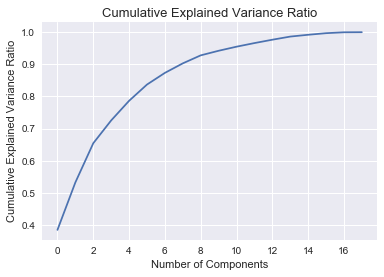

In [18]:
# Plot Cumulative Explained Variance Ratio to check the contribution of each PC to the total variance
# from the plot, we can see that
# first 8 PCs can explain 90% of the variance, 
# first 11 PCs can explain 95% of the variance
# first 15 PCs can explain 99% of the variance
from sklearn.decomposition import PCA
from matplotlib.ticker import MaxNLocator
pca_full = PCA()
X_train_full = pca_full.fit_transform(X_train[cols_rm_vif])
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.plot(cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title("Cumulative Explained Variance Ratio", fontsize=13)
plt.show()

In [19]:
# use 95% as the cutoff to transform the train and test data
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train[cols_rm_vif])
X_test_reduced = pca.transform(X_test[cols_rm_vif])
train_reduced = pd.DataFrame(X_train[cols_rm_vif])
train_reduced['y'] = y_train
pd.DataFrame(X_train_reduced).head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.007742,-0.637361,0.043979,0.403176,-0.193694,0.046192,0.051801,0.196985,0.005908,-0.171474,0.357447
1,-0.007742,-0.637361,0.043979,0.403176,-0.193694,0.046192,0.051801,0.196985,0.005908,-0.171474,0.357447
2,-0.007742,-0.637361,0.043979,0.403176,-0.193694,0.046192,0.051801,0.196985,0.005908,-0.171474,0.357447
3,-1.306303,0.380395,-0.750905,-0.640947,0.507264,1.196550,-0.176775,0.035575,0.014679,-0.045389,-0.103902
4,-1.247457,-0.647666,-0.623151,-0.608946,0.644214,1.095540,-0.244854,0.038395,-0.005200,-0.032590,-0.063754


** Visualize First 4 Principal Components **

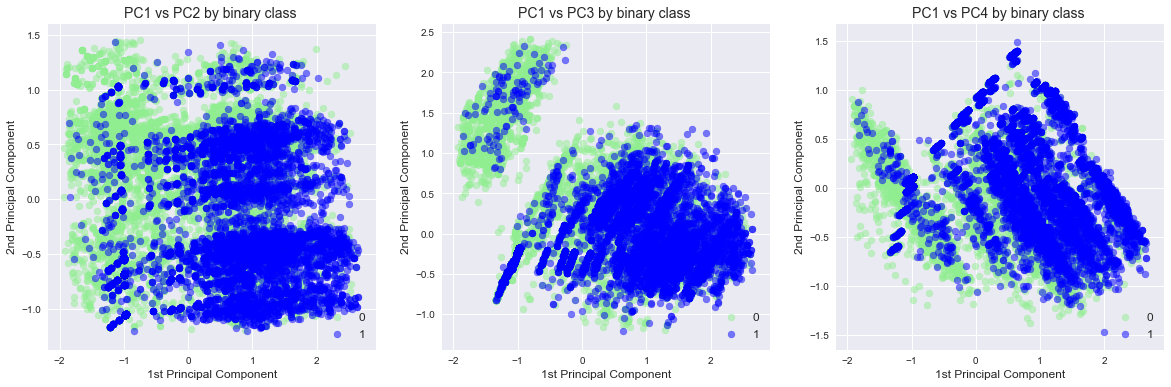

In [20]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(X_train_full[:, 0][np.array(y_train)==0], X_train_full[:, 1][np.array(y_train)==0], color="lightgreen",  alpha=0.5, label="0")
plt.scatter(X_train_full[:, 0][np.array(y_train)==1], X_train_full[:, 1][np.array(y_train)==1], color="blue", alpha=0.5, label="1")
plt.xlabel("1st Principal Component", fontsize=12)
plt.ylabel("2nd Principal Component", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.title("PC1 vs PC2 by binary class ", fontsize=14)
plt.subplot(132)
plt.scatter(X_train_full[:, 0][np.array(y_train)==0], X_train_full[:, 2][np.array(y_train)==0], color="lightgreen",  alpha=0.5, label="0")
plt.scatter(X_train_full[:, 0][np.array(y_train)==1], X_train_full[:, 2][np.array(y_train)==1], color="blue", alpha=0.5, label="1")
plt.xlabel("1st Principal Component", fontsize=12)
plt.ylabel("2nd Principal Component", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.title("PC1 vs PC3 by binary class ", fontsize=14)
plt.subplot(133)
plt.scatter(X_train_full[:, 0][np.array(y_train)==0], X_train_full[:, 3][np.array(y_train)==0], color="lightgreen",  alpha=0.5, label="0")
plt.scatter(X_train_full[:, 0][np.array(y_train)==1], X_train_full[:, 3][np.array(y_train)==1], color="blue",  alpha=0.5, label="1")
plt.xlabel("1st Principal Component", fontsize=12)
plt.ylabel("2nd Principal Component", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.title("PC1 vs PC4 by binary class ", fontsize=14)

# Classifiers
- Apply **standard scaling** to features
- Find the best Linear Model over Linear SVM, Logistic Regression, Perceptron with different levels of regularization using **SGDClassifier** 
- Use **Grid Search** to tune the parameters for each model, F1 score is used as the criteria (over AUC score) due to data imbalance
- n_iter = 3000 is used to approach the full batch model (e.g. sklearn.LogisticRegression) accuracy as much as possible
- Test on upsampling minority class (labeled 1) using class_weight = 'balanced' to compared f1 score

## Linear Model

### Train with unbalanced class
- Train data: comparing using <br/>
        (1) training data with duplicated columns removed only 
        (2) training data with VIF score > 5 removed 
        (3) training data with VIF score > 5 removed and PCA applied after 

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# setting up the pipeline and grid search
linear_pipeline = Pipeline([('std_scaler', StandardScaler()), \
                            ("model", SGDClassifier(n_iter=3000, random_state=1314))
                           ])
linear_pipeline_balanced = Pipeline([('std_scaler', StandardScaler()), \
                            ("model", SGDClassifier(class_weight = 'balanced', n_iter=3000, random_state=1314))
                           ])
loss_options = ['hinge', 'log', 'squared_hinge', 'perceptron']
penalty_options = ['l2', 'elasticnet']
linear_params = {
        'model__loss': loss_options,
        'model__penalty': penalty_options
    }
grid = GridSearchCV(linear_pipeline, cv=5, n_jobs=-1, verbose=1, param_grid=linear_params, scoring='f1')
grid_balanced = GridSearchCV(linear_pipeline_balanced, cv=5, n_jobs=-1, verbose=1, param_grid=linear_params, scoring='f1')

In [22]:
# training data with duplicated columns removed only
grid.fit(X_train_rm, y_train)
print('Best Linear Model: Logistic Regression\n')
best_linear_model = grid.best_estimator_
print(best_linear_model)
predictions = best_linear_model.predict(X_train_rm)
print('----------------\nTrain data prediction:\n')
print(classification_report(y_train, predictions))
predictions = best_linear_model.predict(X_test_rm)
print('----------------\nTest data prediction:\n')
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.6min finished


Best Linear Model: Logistic Regression

Pipeline(steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=3000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=1314, shuffle=True,
       verbose=0, warm_start=False))])
----------------
Train data prediction:

             precision    recall  f1-score   support

          0       0.79      0.91      0.84     19706
          1       0.65      0.42      0.51      8208

avg / total       0.75      0.76      0.75     27914

----------------
Test data prediction:

             precision    recall  f1-score   support

          0       0.78      0.91      0.84      9721
          1       0.65      0.41      0.50      4113

avg / total       0.74      0.76      0.74     13834



In [23]:
## train data with VIF score > 5 removed
grid.fit(X_train_rm[cols_rm_vif], y_train)
best_linear_model_rm_vif = grid.best_estimator_
print('Best Linear Model: \n')
print(best_linear_model_rm_vif)
predictions = best_linear_model_rm_vif.predict(X_train_rm[cols_rm_vif])
print('----------------\nTrain data prediction:\n')
print(classification_report(y_train, predictions))
predictions = best_linear_model_rm_vif.predict(X_test_rm[cols_rm_vif])
print('----------------\nTest data prediction:\n')
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished


Best Linear Model: 

Pipeline(steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=3000, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=1314, shuffle=True,
       verbose=0, warm_start=False))])
----------------
Train data prediction:

             precision    recall  f1-score   support

          0       0.79      0.90      0.84     19706
          1       0.64      0.43      0.51      8208

avg / total       0.75      0.76      0.75     27914

----------------
Test data prediction:

             precision    recall  f1-score   support

          0       0.78      0.90      0.84      9721
          1       0.64      0.42      0.50      4113

avg / total       0.74      0.76      0.74     13834



In [24]:
# training data with VIF score > 5 removed and PCA applied
grid.fit(X_train_reduced, y_train)
print('Best Linear Model: \n')
print(best_linear_model)
best_linear_model_re = grid.best_estimator_
predictions = best_linear_model_re.predict(X_train_reduced)
print('----------------\nTrain data prediction:\n')
print(classification_report(y_train, predictions))
predictions = best_linear_model_re.predict(X_test_reduced)
print('----------------\nTest data prediction:\n')
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished


Best Linear Model: 

Pipeline(steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=3000, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=1314, shuffle=True,
       verbose=0, warm_start=False))])
----------------
Train data prediction:

             precision    recall  f1-score   support

          0       0.79      0.90      0.84     19706
          1       0.64      0.43      0.52      8208

avg / total       0.75      0.76      0.75     27914

----------------
Test data prediction:

             precision    recall  f1-score   support

          0       0.79      0.90      0.84      9721
          1       0.64      0.42      0.51      4113

avg / total       0.74      0.76      0.74     13834



** Summary for Linear Classifier using different transformed training data before class balance ** <br/>
- The classification accuracies are almost the same with three level of transformed data. 
- The major reason can be the little variance across the dataset. <br/>Thus, when removing columns with high correlation, the processing time is reduced but the accuracy remains the same

### Train with balanced class
- The dataset has some imbalance issue (majority class: minority class ~= 2.5:1) <br/>
- In SGDClassifier, set class_weight = 'balanced' so the model will upsample the minority class to make the two classes in equal size
- train data use VIF score > 5 removed and PCA applied for quick processing time

In [25]:
# training data with VIF score > 5 removed and PCA applied
grid_balanced.fit(X_train_reduced, y_train)
print('Best Linear Model: \n')
best_linear_model_re_balanced = grid_balanced.best_estimator_
print(best_linear_model_re_balanced)
predictions = best_linear_model_re_balanced.predict(X_train_reduced)
print('----------------\nTrain data prediction:\n')
print(classification_report(y_train, predictions))
predictions = best_linear_model_re_balanced.predict(X_test_reduced)
print('----------------\nTest data prediction:\n')
print(classification_report(y_test, predictions))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished


Best Linear Model: 

Pipeline(steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_hinge', n_iter=3000,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=1314,
       shuffle=True, verbose=0, warm_start=False))])
----------------
Train data prediction:

             precision    recall  f1-score   support

          0       0.85      0.71      0.78     19706
          1       0.51      0.71      0.59      8208

avg / total       0.75      0.71      0.72     27914

----------------
Test data prediction:

             precision    recall  f1-score   support

          0       0.85      0.71      0.77      9721
          1       0.50      0.70      0.58      4113

avg / total       0.74      0.70      0.71     13834



In [26]:
import pickle
# save best Linear Classifier - Logistic Regression
pickle.dump(best_linear_model, open('best_linear_classifier.sav', 'wb'))

### Linear Classifier Result Summary 

- The best linear model picked up by grid search is Logistic Regression with L2 regularization using unbalanced train data
- Comparing the training and testing scores (precision, recall and F1), we can see that the scores are pretty close, indicating that the model is neither overfitting nor underfitting
- We can see that the minority class has a lower precision and a higher recall (almost the same with majority class) after upsampling of the minority class (label 1) in training data while using unbalanced training data, the precision for minority class is higher but recall is much lower

## Non-linear Model
- Find the best Non-Linear Model over KNN, Random Forest and Multilayer Perceptron models
- Gradient Boosting classifier, while less prune to overfitting compared to Random Forest, is computationally expensive for this dataset if we want to tune the hyperparameters. Thus, I used Random Forest only and compared both training and test scores to prevent overfitting

In [27]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [28]:
# Returns the best paramsuration for a model using crosvalidation
# and grid search
def best_params(model, name, parameters, X, y):
    print('Start to search best hyperparameters for classifier - ' + name)
    grid = GridSearchCV(model, parameters, cv=5,
                       scoring="f1", verbose=1)
    grid.fit(X, y)
    best_estimator = grid.best_estimator_
    print('Best model: ', best_estimator)
 
    return [name, grid.best_score_, best_estimator]

# Returns the best model from a set of model families given
# training data using cross-validation.
def best_model(classifier_group, X, y):
    best_score = 0.0
    best_classifier = None
    classifiers = []
    for name, model, parameters in classifier_group:
        classifiers.append(best_params(model, name, parameters, X, y))
 
    for name, score, classifier in classifiers:
        if (score > best_score):
            best_score = score
            best_classifier = [name, classifier]
            
    return best_classifier[1]
 
# List of candidate family classifiers with parameters for grid
# search [name, classifier object, parameters].
def nonlinear_models():
    models = []
 
    rf_tuned_parameters = [{'criterion': ['gini', 'entropy'],
                            'max_depth' : [5, 10, 20, 50],
                            'min_samples_leaf' : [1, 5, 10, 20]}]
    models.append(['RandomForest', RandomForestClassifier(n_jobs=-1,random_state=1314), rf_tuned_parameters])
    
    
    
    knn_tuned_parameters = [{"n_neighbors": [5, 10, 20, 50]}]
    models.append(['kNN', KNeighborsClassifier(n_jobs=-1), knn_tuned_parameters])
    
    
    mlp_tuned_parameters = [{'learning_rate': ['invscaling', 'adaptive'],
                             'activation': ['relu', 'logistic'],
                             "hidden_layer_sizes": [(10,), (15,), (20,), (10,5), (15,5), (20,5)]}]
    models.append(['MLP', MLPClassifier(random_state=1314),  mlp_tuned_parameters])
    return models

In [29]:
best_nonlinear_model = best_model(nonlinear_models(), X_train, y_train)

Start to search best hyperparameters for classifier - RandomForest
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.3min finished


('Best model: ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1314,
            verbose=0, warm_start=False))
Start to search best hyperparameters for classifier - kNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.6min finished


('Best model: ', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
           weights='uniform'))
Start to search best hyperparameters for classifier - MLP
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  3.3min finished


('Best model: ', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1314,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))


In [30]:
best_nonlinear_model_downsampling = best_model(nonlinear_models(), X_train_ds, y_train_ds)

Start to search best hyperparameters for classifier - RandomForest
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.4min finished


('Best model: ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1314,
            verbose=0, warm_start=False))
Start to search best hyperparameters for classifier - kNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   50.1s finished


('Best model: ', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
           weights='uniform'))
Start to search best hyperparameters for classifier - MLP
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.5min finished


('Best model: ', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 5), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1314,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))


In [31]:
best_nonlinear_model_downsampling_rm_vif = best_model(nonlinear_models(), X_train_ds[cols_rm_vif], y_train_ds)

Start to search best hyperparameters for classifier - RandomForest
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.4min finished


('Best model: ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1314,
            verbose=0, warm_start=False))
Start to search best hyperparameters for classifier - kNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   21.3s finished


('Best model: ', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
           weights='uniform'))
Start to search best hyperparameters for classifier - MLP
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.0min finished


('Best model: ', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 5), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1314,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))


In [32]:
best_nonlinear_model_reduced = best_model(nonlinear_models(), X_train_reduced, y_train)

Start to search best hyperparameters for classifier - RandomForest
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.3min finished


('Best model: ', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1314,
            verbose=0, warm_start=False))
Start to search best hyperparameters for classifier - kNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   12.5s finished


('Best model: ', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=50, p=2,
           weights='uniform'))
Start to search best hyperparameters for classifier - MLP
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.1min finished


('Best model: ', MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1314,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))


** Best Non-Linear Model - data with all features **

In [33]:
print(best_nonlinear_model)
predictions = best_nonlinear_model.predict(X_train)
print('----------------\nTrain data prediction:\n')
print(classification_report(y_train, predictions))
predictions = best_nonlinear_model.predict(X_test)
print('----------------\nTest data prediction:\n')
print(classification_report(y_test, predictions))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1314,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
----------------
Train data prediction:

             precision    recall  f1-score   support

          0       0.80      0.90      0.84     19706
          1       0.65      0.46      0.53      8208

avg / total       0.75      0.77      0.75     27914

----------------
Test data prediction:

             precision    recall  f1-score   support

          0       0.79      0.89      0.84      9721
          1       0.63      0.44      0.52      4113

avg / total       0.74      0.76      0.74     13834



** Best Non-Linear Model - downsampling data with all features **

In [34]:
print(best_nonlinear_model_downsampling)
predictions = best_nonlinear_model_downsampling.predict(X_train_ds)
print('----------------\nTrain data prediction:\n')
print(classification_report(y_train_ds, predictions))
predictions = best_nonlinear_model_downsampling.predict(X_test)
print('----------------\nTest data prediction:\n')
print(classification_report(y_test, predictions))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 5), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1314,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
----------------
Train data prediction:

             precision    recall  f1-score   support

          0       0.73      0.70      0.72      8208
          1       0.71      0.74      0.73      8208

avg / total       0.72      0.72      0.72     16416

----------------
Test data prediction:

             precision    recall  f1-score   support

          0       0.86      0.70      0.77      9721
          1       0.50      0.73      0.60      4113

avg / total       0.75      0.71      0.72     13834



** Best Non-Linear Model - data with VIF > 5 removed and PCA applied**

In [35]:
print(best_nonlinear_model_reduced)
predictions = best_nonlinear_model_reduced.predict(X_train_reduced)
print('----------------\nTrain data prediction:\n')
print(classification_report(y_train, predictions))
predictions = best_nonlinear_model_reduced.predict(X_test_reduced)
print('----------------\nTest data prediction:\n')
print(classification_report(y_test, predictions))

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 5), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1314,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
----------------
Train data prediction:

             precision    recall  f1-score   support

          0       0.80      0.88      0.84     19706
          1       0.62      0.48      0.54      8208

avg / total       0.75      0.76      0.75     27914

----------------
Test data prediction:

             precision    recall  f1-score   support

          0       0.80      0.88      0.83      9721
          1       0.62      0.47      0.53      4113

avg / total       0.74      0.76      0.74     13834



** Best Non-Linear Model - downsampling data data with VIF > 5 removed (PCA not applied)**

In [36]:
print(best_nonlinear_model_downsampling_rm_vif)
predictions = best_nonlinear_model_downsampling_rm_vif.predict(X_train_ds[cols_rm_vif])
print('----------------\nTrain data prediction:\n')
print(classification_report(y_train_ds, predictions))
predictions = best_nonlinear_model_downsampling_rm_vif.predict(X_test[cols_rm_vif])
print('----------------\nTest data prediction:\n')
print(classification_report(y_test, predictions))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 5), learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1314,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
----------------
Train data prediction:

             precision    recall  f1-score   support

          0       0.73      0.71      0.72      8208
          1       0.71      0.74      0.73      8208

avg / total       0.72      0.72      0.72     16416

----------------
Test data prediction:

             precision    recall  f1-score   support

          0       0.86      0.70      0.77      9721
          1       0.51      0.73      0.60      4113

avg / total       0.76      0.71      0.72     13834



** Non-linear Classifier Summary** <br/>
- The model with highest avearge F1 score is MLPClassifier, and the activation function or hidden layer size change do not really make a difference. While Random Forest can also give higher F1 Score in the training data, it is prune to overfit the model and get a slightly unstable test accuracy. So MLPClassifier should be the best model compared Random Forest, KNN and its computation complexity is not too expensive for this dataset.
- Similar to Linear model, the model accuracy remains the same after removing duplicated or colinear features and additionally reducing dimensions using PCA.
- Non-linear classifier without downsampling has a higher precision and a lower recall compared to the one with balanced samples. <br/> It makes sense because for model trained using balanced data, it tends predict based on the learning that the minority class is as frequent as the majority class, which is not true for test data.


## Note for Picking the Best Model
- Although we can pick the best model by selectint the one with the highest average f1 score, in real world, it is important to think about the business question we are trying to solve. For example, if the business question wants to make sure true class 1 is predicted as class 1, than higher precision of class 1 is preferred. On the opposite, if falsely predicting class 0 as class 1 is very bad, then higer recall of class 1 is preffered
- Due to the fact that this dataset do not have a lot of complexity in it, a simple Logistic Regression model should be the quick and robust way to trackle the problem. Using Neural Network and adding more hidden layers would be an overkill.

# Importance Rank

In [37]:
# Considering that Logistic Regression is the best in this classification problem, 
# I will use magnitude of the model coefficient times the corresponding standard deviation to rank the importance of features
# Features that are removed the input are not ranked 
logreg = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=3000, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=1314, shuffle=True,
       verbose=0, warm_start=False)
logreg.fit(X_train[cols_rm_vif], y_train)
importance = pd.DataFrame(np.std(np.array(X_train[cols_rm_vif]), 0)*abs(logreg.coef_), columns = cols_rm_vif).T.rename(columns = {0: 'standardized adsolute coefficient'})
importance = importance.sort_values('standardized adsolute coefficient', ascending=False)

In [38]:
# calculate person correlation
pearson_correlation_rank = pd.DataFrame(train[[0]+cols_rm_vif].corr().ix[0].T.sort_values(ascending=False)).rename(columns={0: 'pearson correlation'})

In [39]:
# calculate importance by Random Forest classifier
rf = RandomForestClassifier(criterion='entropy',max_depth=20, min_samples_leaf=5, random_state=1314)
rf.fit(X_train[cols_rm_vif], y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1314,
            verbose=0, warm_start=False)

In [40]:
rf_importance = pd.DataFrame(rf.feature_importances_).T
rf_importance.columns = cols_rm_vif
rf_importance = rf_importance.T.sort_values(0, ascending=False).rename(columns={0: 'random forest importance'})

** Comparing 3 ranks **
- [standardized adsolute coefficient] is the standardized magnitude of Logistic Regression coefficients 
- [random forest importance] is the feature importance extacted from the random forest model
- [pearson correlation] measures the linear relationship with dependent variable column 0
- comparing the 3 ranks, we can see that ranks are pretty similar across the board. 
- Looking at the correlation matrix for top 5 important features, their correlations are pretty close to 0 as well, and that is why they cover the major variation in the dataset

In [41]:
syn_rank = pd.merge(pd.merge(importance.reset_index(), rf_importance.reset_index()), \
                    pearson_correlation_rank.reset_index()).set_index('index')
syn_rank

,standardized adsolute coefficient,random forest importance,pearson correlation
index,,,
6,0.658749,0.260411,0.270849
94,0.618275,0.261160,0.336226
3,0.311468,0.089481,0.145618
67,0.276491,0.078800,0.224534
38,0.170501,0.032034,0.082750
52,0.143851,0.035364,0.184299
5,0.091149,0.071490,0.201010
92,0.090228,0.040881,0.184023
4,0.090031,0.048235,0.196083


In [42]:
# correlation matrix for top 5 important features
train[[6,94,3,67,38]].corr()

,6,94,3,67,38
6,1.000000,0.045449,0.101751,0.047194,0.042224
94,0.045449,1.000000,0.016918,0.491163,0.083223
3,0.101751,0.016918,1.000000,0.233238,0.163639
67,0.047194,0.491163,0.233238,1.000000,-0.128763
38,0.042224,0.083223,0.163639,-0.128763,1.000000


**Rank for Features Importance ** <br/>
- 6, 94, 3, 67, 38, 52, 5, 92, 4, 19, 91, 40, 24, 93, 41, 23, 95, 39
- all the remaining columns are not selected in the model, so has no importance